In [1]:
import os
import time
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from scipy.interpolate import interp1d
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import model
import utils
import train

torch.manual_seed(42)
torch.cuda.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load data

In [2]:
dir_path = '/home/scar/Desktop/sanghoon/crois/data/splitted_100ms'

train_tnum = 'T1'
test_tnum = 'T5'

Tx_train = utils.preprocess_data(train_tnum, dir_path)
Tx_test = utils.preprocess_data(test_tnum, dir_path)

train_slice = Tx_train[Tx_train['Expt'].isin([1, 2])].drop(columns=['Expt']).to_numpy()  # Expt 1, 2만 사용
train_slice, val_slice = utils.stratified_sampling(train_slice, 0.15)

scaler = StandardScaler()
train_slice_scaled = scaler.fit_transform(train_slice)
val_slice_scaled = scaler.transform(val_slice)
test_scaled = scaler.transform(Tx_test.drop(columns=['Expt']).to_numpy())

# Convert data to PyTorch tensors
X_train = torch.tensor(train_slice_scaled, dtype=torch.float32).cuda()
X_val = torch.tensor(val_slice_scaled, dtype=torch.float32).cuda()
X_test = torch.tensor(test_scaled, dtype=torch.float32).cuda()

# model train

In [3]:
# DataLoader 설정
train_loader = DataLoader(TensorDataset(X_train), batch_size=128, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val), batch_size=128, shuffle=False)

# Autoencoder 모델 초기화
input_dim = X_train.shape[1]
model = model.Autoencoder(input_dim).cuda()
model.preprocessor = scaler

# Loss 함수와 Optimizer 설정
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
trained_model, train_loss, val_loss = train.train_model(model, train_loader, val_loader, criterion, optimizer, device, n_epochs=30)

model_path = "model.pkl"
preprocessor_path = "preprocessor.pkl"
model.save(model_path, preprocessor_path)

Epoch [1/30], Loss: 0.0445, Val Loss: 0.0181 (Best model)
Epoch [2/30], Loss: 0.0254, Val Loss: 0.0204
Epoch [3/30], Loss: 0.0235, Val Loss: 0.0166 (Best model)
Epoch [4/30], Loss: 0.0221, Val Loss: 0.0066 (Best model)
Epoch [5/30], Loss: 0.0204, Val Loss: 0.0094
Epoch [6/30], Loss: 0.0190, Val Loss: 0.0067
Epoch [7/30], Loss: 0.0182, Val Loss: 0.0064 (Best model)
Epoch [8/30], Loss: 0.0174, Val Loss: 0.0066
Epoch [9/30], Loss: 0.0179, Val Loss: 0.0053 (Best model)
Epoch [10/30], Loss: 0.0162, Val Loss: 0.0064
Epoch [11/30], Loss: 0.0160, Val Loss: 0.0092
Epoch [12/30], Loss: 0.0165, Val Loss: 0.0063
Epoch [13/30], Loss: 0.0161, Val Loss: 0.0051 (Best model)
Epoch [14/30], Loss: 0.0154, Val Loss: 0.0034 (Best model)
Epoch [15/30], Loss: 0.0149, Val Loss: 0.0043
Epoch [16/30], Loss: 0.0146, Val Loss: 0.0040
Epoch [17/30], Loss: 0.0151, Val Loss: 0.0046
Epoch [18/30], Loss: 0.0150, Val Loss: 0.0051
Epoch [19/30], Loss: 0.0143, Val Loss: 0.0056
Epoch [20/30], Loss: 0.0148, Val Loss: 0.003


Results:
Training -> Validation: Best Val Loss = 0.0030


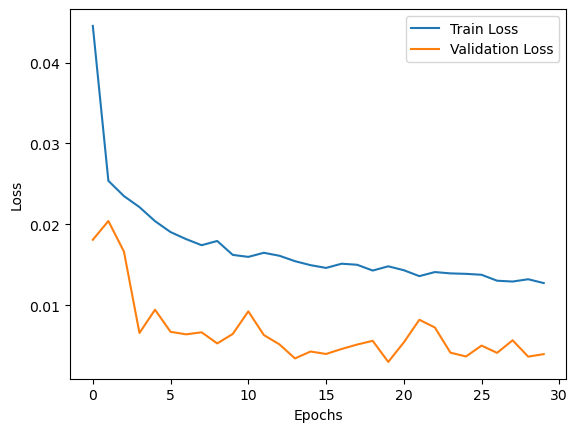

In [4]:
print("\nResults:")
print(f"Training -> Validation: Best Val Loss = {min(val_loss):.4f}")

plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

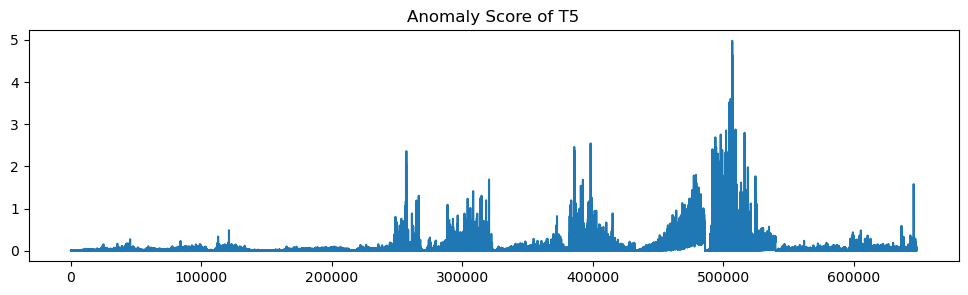

In [5]:
score_test = train.evaluate_model(trained_model, X_test)

plt.figure(figsize=(12, 3))
plt.plot(score_test)
plt.title(f'Anomaly Score of {test_tnum}')
plt.show()

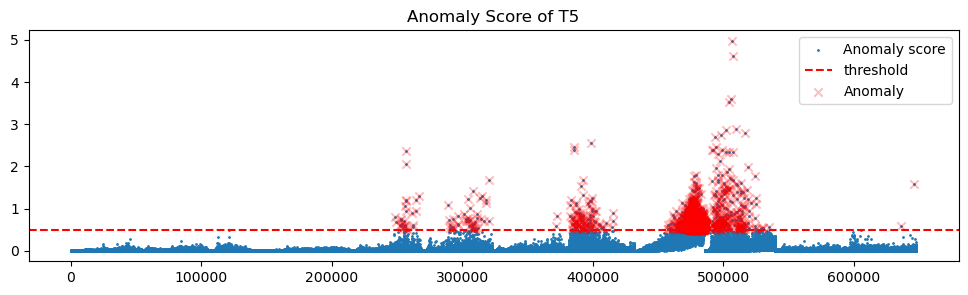

In [6]:
th = 0.5
anomalies = score_test > th
anomaly_indices = np.where(anomalies)[0]
plt.figure(figsize=(12, 3))
plt.scatter(range(len(score_test)), score_test, s=1, label='Anomaly score')
plt.axhline(y=th, c='red', linestyle='--', label='threshold')
plt.scatter(anomaly_indices, score_test[anomaly_indices], marker='x', c='red', alpha=0.25, label='Anomaly')
plt.title(f'Anomaly Score of T5')
plt.legend()
plt.show()

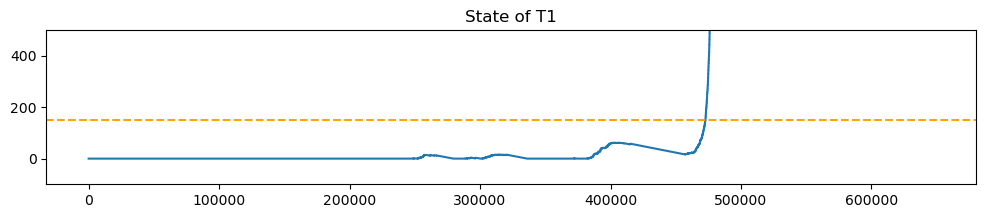

In [8]:
train_data_for_test = Tx_train.drop(columns=['Expt']).to_numpy()
scaled_data = scaler.transform(train_data_for_test)
X_train_data_for_test = torch.tensor(scaled_data, dtype=torch.float32).cuda()

score_t1 = train.evaluate_model(trained_model, X_train_data_for_test)
state_t1 = train.health_index(score_t1, th=0.5, increase_step=1, decrease_step=0.001)

plt.figure(figsize=(12, 2))
plt.plot(state_t1)
plt.ylim(-100, 500)
plt.axhline(y=150, linestyle='--', c='orange')  # Health index에서 normal vs anomaly `threshold = 100`으로 설정
plt.title(f'State of T1')
plt.show()

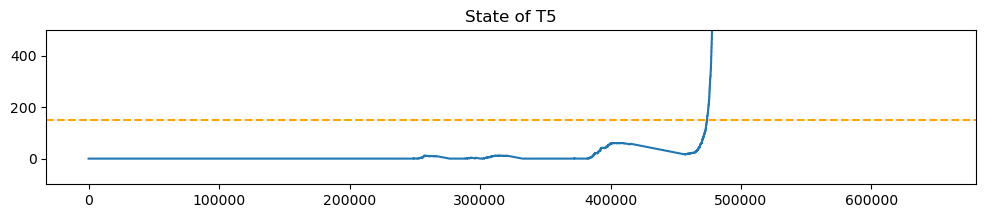

In [9]:
state_t5 = train.health_index(score_test, th=0.5, increase_step=1, decrease_step=0.001)

plt.figure(figsize=(12, 2))
plt.plot(state_t5)
plt.ylim(-100, 500)
plt.axhline(y=150, linestyle='--', c='orange')  # Health index에서 normal vs anomaly `threshold = 100`으로 설정
plt.title(f'State of T5')
plt.show()

In [10]:
predicted_labels = np.where(np.array(state_t5)>150, 1, 0)

# 데이터 길이에 맞게 tool wear 값 interpolate & 라벨링
toolwear_df = pd.read_csv(os.path.join(dir_path, test_tnum, f'{test_tnum}_all_labels.csv'))

index = toolwear_df.index
toolwear = toolwear_df['Tool Wear in (µm)'].values

f_nearest = interp1d(index, toolwear, kind='nearest')

index_new = np.linspace(index.min(), index.max(), len(score_test))
toolwear_new = f_nearest(index_new)

# tool wear 값 250 이상이면 anomaly
labels = np.where(toolwear_new>=250, 1, 0)

In [11]:
# 평가 지표 계산
accuracy = accuracy_score(labels, predicted_labels)
precision = precision_score(labels, predicted_labels)
recall = recall_score(labels, predicted_labels)
f1 = f1_score(labels, predicted_labels)
conf_matrix = confusion_matrix(labels, predicted_labels)

# 결과 출력
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.97
Precision: 0.87
Recall: 1.00
F1-Score: 0.93
Confusion Matrix:
[[473975  22151]
 [     0 151874]]
